*After querying my data in workbench, I use python to visualize trends that I want to investigate further based on insights I was able to gather from playing with the data*

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
plt.style.use('ggplot')
from datetime import date

### Loading in the data

In [2]:
shifts = pd.read_csv('shifts.csv')
#shifts.head(10)

*The below is the original dataframe displaying shift views, the above is a table created in MySQL to understand values related to distinct shifts. To understand trends in the date as well as the time a shift takes place, I manipulated my dataframe to include the start date of a shift.*

In [3]:
shift_views = pd.read_csv('2024_Q3Q4_Shift_Views.csv')
#shift_views.head()

In [4]:
# Data manipulation for shift start times
shift_views['SHIFT_START_AT'] = pd.to_datetime(shift_views['SHIFT_START_AT'])
unique_start_times = shift_views.groupby('SHIFT_ID')['SHIFT_START_AT'].first().reset_index()
unique_start_times = unique_start_times.rename(columns={'SHIFT_START_AT': 'shift_start_at'})
shifts = pd.merge(shifts, unique_start_times, on='SHIFT_ID', how='left')
shifts.head(10)

,SHIFT_ID,time_posted_before_shift,hr_duration,shift_slot,total_num_views,min_offer,max_offer,avg_offer,accepted_rate,shift_status,shift_start_at
0,6757580b1e2d97752fd69167,02:09:41,8,pm,64,21.05,23.07,21.98,NaN,Unclaimed,2024-12-09 23:00:00
1,675d37d8a1ca6192a74d23f4,14:43:28,9,pm,129,23.05,25.23,24.18,NaN,Deleted,2024-12-14 22:30:00
2,67550bddd79613f860549322,11:59:14,6,am,6,21.67,34.47,23.94,34.47,Worked,2024-12-08 15:00:00
3,66f5d05de01fd3697b18c206,16:38:26,8,am,99,19.02,20.17,19.58,NaN,Unclaimed,2024-09-27 14:00:00
4,66ee3848e62bb5f43e3baee5,426:23:12,8,pm,38,21.35,36.28,23.01,35.19,Worked,2024-10-08 21:30:00
5,67254195894c05fb0e389089,16:58:51,8,am,11,21.41,22.60,21.87,NaN,Unclaimed,2024-11-02 14:00:00
6,677b553df0e33d9606282ec6,02:00:02,8,noc,4,33.39,34.02,33.68,33.39,Worked,2025-01-06 06:00:00
7,6709378437c8617d291cb35f,382:25:16,8,am,13,21.11,39.17,29.45,37.67,Worked,2024-10-27 13:00:00
8,6747959cb122747e61a85baf,753:03:15,8,noc,20,20.82,37.77,22.21,NaN,Unclaimed,2024-12-29 07:00:00
9,67854c3deb70a77b480da8cb,51:35:46,4,am,2,19.95,19.96,19.95,NaN,Deleted,2025-01-15 21:00:00


### Date & Time Visualization

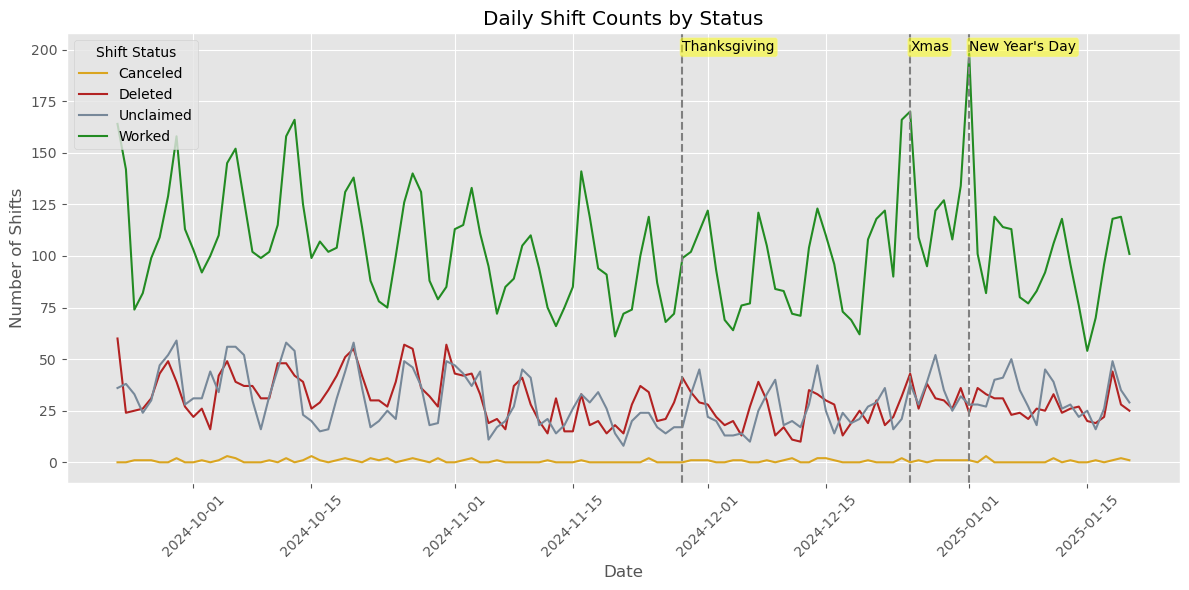

In [8]:
# Date aggregation by day
shifts['date'] = shifts['shift_start_at'].dt.date
daily_shift_counts = shifts.groupby(['date', 'shift_status']).size().unstack(fill_value=0)

#Marking holidays for chart marking
holidays = {
    date(2024, 11, 28): "Thanksgiving",  # Thanksgiving
    date(2024, 12, 25): "Xmas",     # Christmas
    date(2025, 1, 1): "New Year's Day"   # New Year's Day
}


plt.figure(figsize=(12, 6))

# Color palette for shift statuses 
status_colors = {
    'Worked': 'forestgreen',
    'Canceled': 'goldenrod',
    'Deleted': 'firebrick',
    'Unclaimed': 'lightslategray'
}

for status in daily_shift_counts.columns:
    color = status_colors.get(status)  
    if color:  
        plt.plot(daily_shift_counts.index, daily_shift_counts[status], label=status, color=color)
    else:
        plt.plot(daily_shift_counts.index, daily_shift_counts[status], label=status)

for holiday_date, holiday_name in holidays.items():
    if holiday_date in daily_shift_counts.index:  
        plt.axvline(x=holiday_date, color='gray', linestyle='--')
        plt.annotate(holiday_name, xy=(holiday_date, plt.gca().get_ylim()[1]),  
                     xytext=(0, -5), textcoords='offset points', ha='left', va='top',
                     bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.5))  


plt.xlabel('Date')
plt.ylabel('Number of Shifts')
plt.title('Daily Shift Counts by Status')
plt.legend(title='Shift Status', loc='upper left')
plt.grid(True)  
plt.xticks(rotation=45)  
plt.tight_layout()  
plt.show()

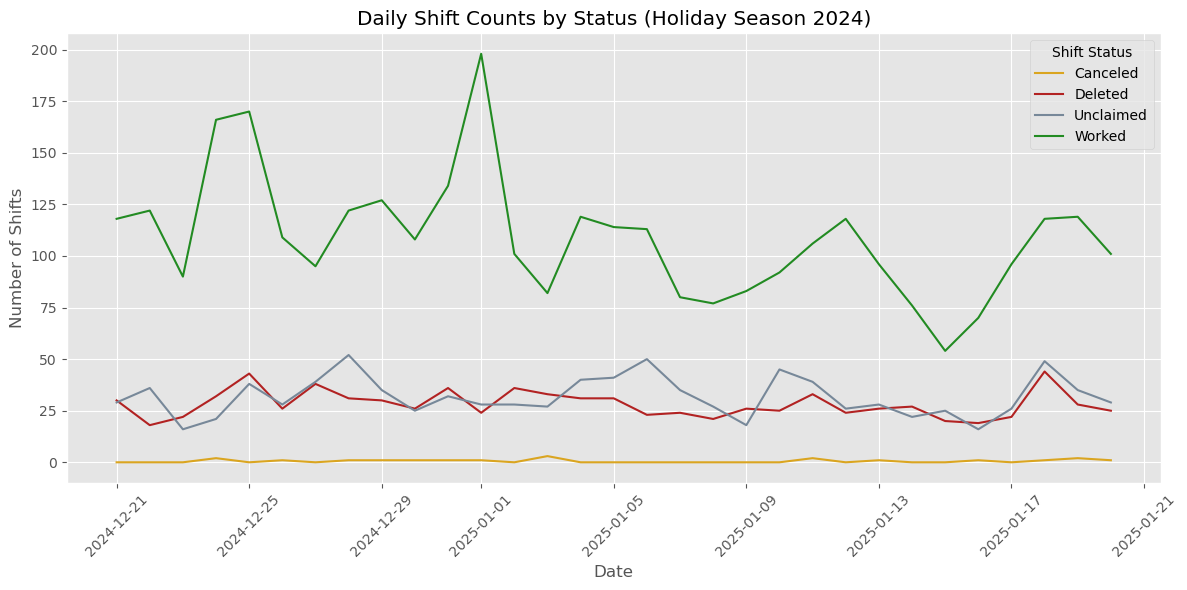

In [9]:
# Filter for the last 30 days
last_30_days = daily_shift_counts.index.max() - pd.Timedelta(days=30)
daily_shift_counts_last_30 = daily_shift_counts[daily_shift_counts.index >= last_30_days]

plt.figure(figsize=(12, 6))

for status in daily_shift_counts_last_30.columns:
    color = status_colors.get(status)
    if color:
        plt.plot(daily_shift_counts_last_30.index, daily_shift_counts_last_30[status], label=status, color=color)
    else:
        plt.plot(daily_shift_counts_last_30.index, daily_shift_counts_last_30[status], label=status)

plt.xlabel('Date')
plt.ylabel('Number of Shifts')
plt.title('Daily Shift Counts by Status (Holiday Season 2024)') 
plt.legend(title='Shift Status')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

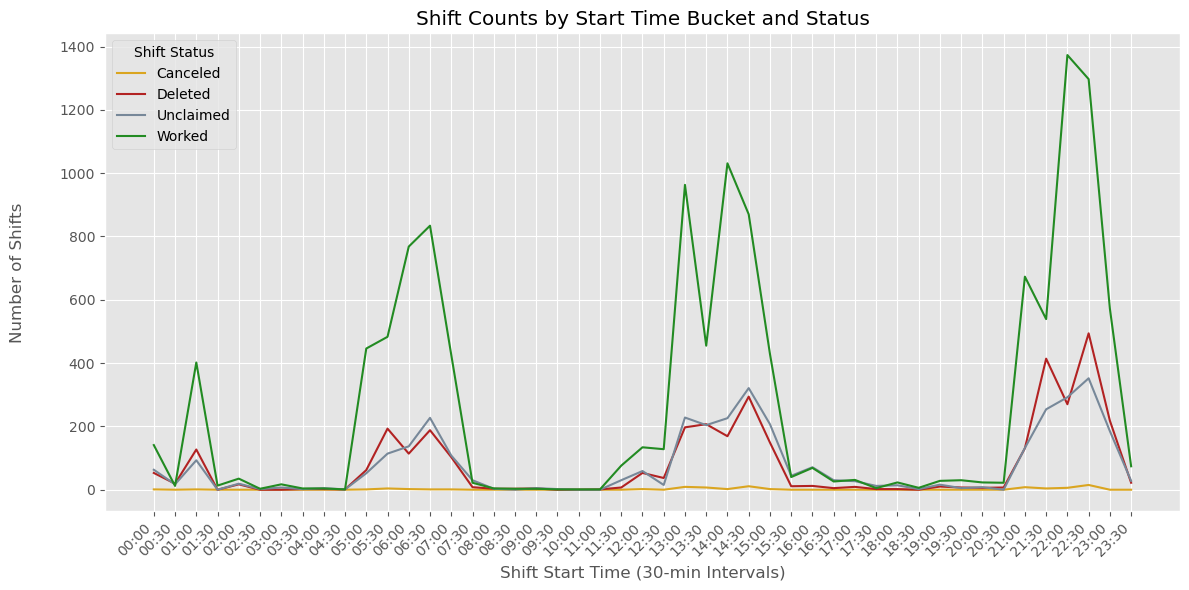

In [10]:
# Date aggregation by time
shifts['shift_start_time'] = shifts['shift_start_at'].dt.time

# Bucket into 30-minute intervals
def categorize_time(time_obj):
    minutes = time_obj.hour * 60 + time_obj.minute
    bucket = minutes // 30  
    start_minutes = bucket * 30
    end_minutes = start_minutes + 30
    start_hour = start_minutes // 60
    start_minute = start_minutes % 60
    end_hour = end_minutes // 60
    end_minute = end_minutes % 60

    start_time_str = f"{start_hour:02d}:{start_minute:02d}"

    return start_time_str

shifts['time_bucket'] = shifts['shift_start_time'].apply(categorize_time)

#group by time and shift status, count the shifts
hourly_shift_counts = shifts.groupby(['time_bucket', 'shift_status']).size().unstack(fill_value=0)


plt.figure(figsize=(12, 6))

for status in hourly_shift_counts.columns:
    color = status_colors.get(status)
    if color:
        plt.plot(hourly_shift_counts.index, hourly_shift_counts[status], label=status, color=color)
    else:
        plt.plot(hourly_shift_counts.index, hourly_shift_counts[status], label=status)

plt.xlabel('Shift Start Time (30-min Intervals)')  
plt.ylabel('Number of Shifts', labelpad=25)
plt.title('Shift Counts by Start Time Bucket and Status') 
plt.legend(title='Shift Status')
plt.grid(True)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

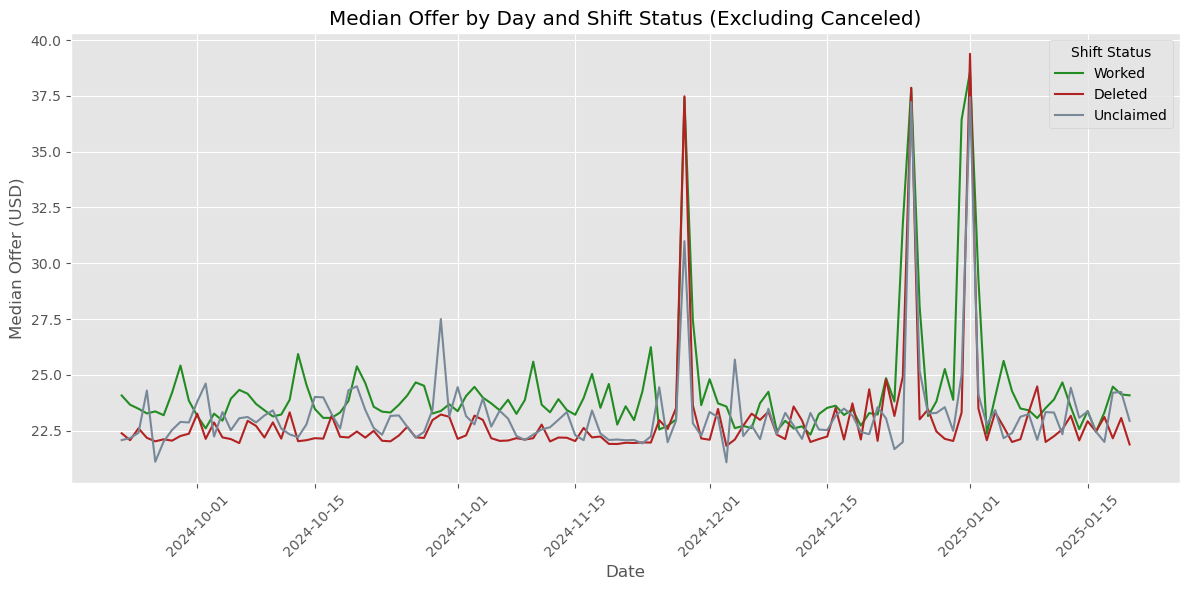

In [12]:
# median avg offer by shift status by date
average_rate_by_day = shifts.groupby(['date', 'shift_status'])['avg_offer'].median().unstack(fill_value=0)

# drop the 'Canceled' to clarify chart as quite low rates
average_rate_by_day = average_rate_by_day.drop(columns='Canceled')


plt.figure(figsize=(12, 6))
for status, color in status_colors.items():
    if status in average_rate_by_day.columns:  
        plt.plot(
            average_rate_by_day.index,
            average_rate_by_day[status],
            label=status,
            color=color
        )

plt.title('Median Offer by Day and Shift Status (Excluding Canceled)')  
plt.xlabel('Date')
plt.ylabel('Median Offer (USD)')  
plt.legend(title='Shift Status')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

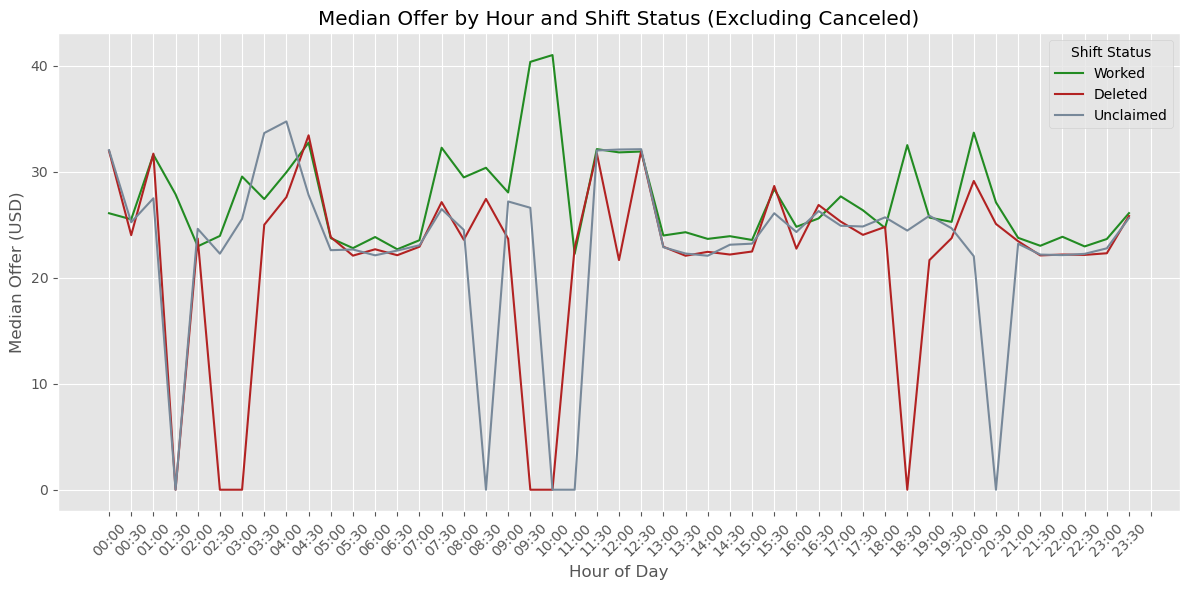

In [15]:

median_rate_by_hour = shifts.groupby(['time_bucket', 'shift_status'])['avg_offer'].median().unstack(fill_value=0)
median_rate_by_hour = median_rate_by_hour.drop(columns='Canceled', errors='ignore')  # errors='ignore' handles cases where 'Canceled' might not be present

plt.figure(figsize=(12, 6))

for status, color in status_colors.items():
    if status in median_rate_by_hour.columns:  
        plt.plot(
            median_rate_by_hour.index,
            median_rate_by_hour[status],
            label=status,
            color=color
        )

plt.title('Median Offer by Hour and Shift Status (Excluding Canceled)')
plt.xlabel('Hour of Day')
plt.ylabel('Median Offer (USD)')
plt.legend(title='Shift Status')
plt.grid(True)
plt.xticks(range(48), rotation=45)  
plt.tight_layout()
plt.show()

In [16]:

def time_to_hours(time_str):
    if not isinstance(time_str, str):  
        return None  
    match = re.match(r'(\d+):(\d+):(\d+)', time_str)
    if match:
        hours = int(match.group(1))
        minutes = int(match.group(2))
        seconds = int(match.group(3))
        total_hours = hours + minutes / 60 + seconds / 3600
        return int(total_hours) 
    return None  

shifts['time_posted_before_shift_hours'] = shifts['time_posted_before_shift'].apply(time_to_hours)
print(shifts[['SHIFT_ID', 'time_posted_before_shift', 'time_posted_before_shift_hours']])
print("\nData type of the new column:")
print(shifts['time_posted_before_shift_hours'].dtype)

                       SHIFT_ID time_posted_before_shift  \
0      6757580b1e2d97752fd69167                 02:09:41   
1      675d37d8a1ca6192a74d23f4                 14:43:28   
2      67550bddd79613f860549322                 11:59:14   
3      66f5d05de01fd3697b18c206                 16:38:26   
4      66ee3848e62bb5f43e3baee5                426:23:12   
...                         ...                      ...   
19895  6779e56223aaa8c3269252ba                 04:39:33   
19896  67002f13bd4437a550b6cd48                 03:51:40   
19897  66f30f8c1b23114840850662                 41:45:40   
19898  671a0f33dbb054d29836f340                477:18:44   
19899  675efae1e882e3a34cfca759                174:09:02   

       time_posted_before_shift_hours  
0                                 2.0  
1                                14.0  
2                                11.0  
3                                16.0  
4                               426.0  
...                               ...  

In [17]:
# Summary of aggregated columns made via SQL
shifts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19900 entries, 0 to 19899
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   SHIFT_ID                        19900 non-null  object        
 1   time_posted_before_shift        19900 non-null  object        
 2   hr_duration                     19900 non-null  int64         
 3   shift_slot                      19900 non-null  object        
 4   total_num_views                 19900 non-null  int64         
 5   min_offer                       19900 non-null  float64       
 6   max_offer                       19900 non-null  float64       
 7   avg_offer                       19900 non-null  float64       
 8   accepted_rate                   12541 non-null  float64       
 9   shift_status                    19900 non-null  object        
 10  shift_start_at                  19900 non-null  datetime64[ns]
 11  da

In [18]:
within_24_hours_per = round(len(shifts.loc[shifts['time_posted_before_shift_hours'] < 24])/len(shifts),3) * 100
print(f'Out of nearly 20,000 shifts made available on Clipboard Health from July 2024 to January 2025, {within_24_hours_per}% were posted within 24 hours of their assigned start date.')

Out of nearly 20,000 shifts made available on Clipboard Health from July 2024 to January 2025, 33.0% were posted within 24 hours of their assigned start date.


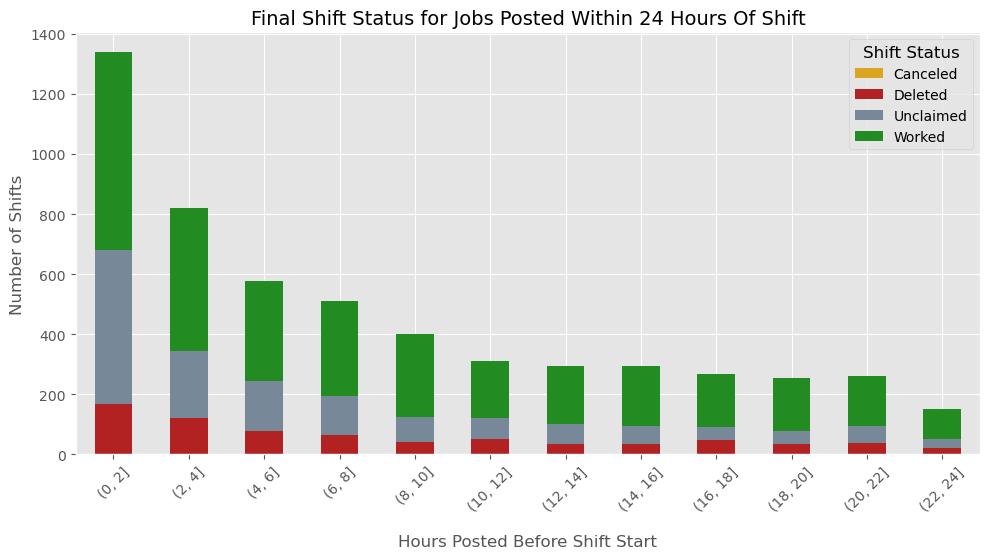

In [19]:
# Filter data for values under 24 hours
under_24_hours = shifts[shifts['time_posted_before_shift_hours'] < 24]
grouped = under_24_hours.groupby([pd.cut(under_24_hours['time_posted_before_shift_hours'], bins=range(0, 25, 2)), 'shift_status']).size().unstack()

# Stacked bar chart
ax = grouped.plot(kind='bar', stacked=True, figsize=(10, 6), color=status_colors)

plt.title('Final Shift Status for Jobs Posted Within 24 Hours Of Shift', fontsize=14)  
plt.xlabel('Hours Posted Before Shift Start', fontsize=12, labelpad=15)  
plt.ylabel('Number of Shifts', fontsize=12)  

plt.xticks(rotation=45, fontsize=10) 
plt.yticks(fontsize=10) 
handles, labels = ax.get_legend_handles_labels() 
plt.legend(handles, ['Canceled', 'Deleted', 'Unclaimed', 'Worked'], 
           title='Shift Status', fontsize=10,  
           title_fontsize=12, loc='upper right') 

plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()

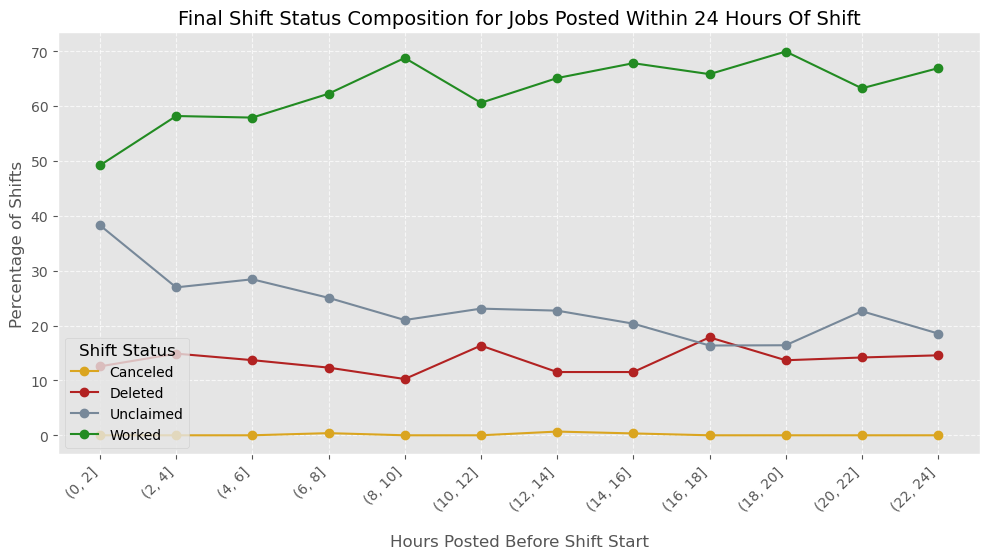

In [20]:
# Calculate percentages for each group
percentages = grouped.apply(lambda x: x / x.sum() * 100, axis=1)

# Plotting the line graph of percentages
plt.figure(figsize=(10, 6)) 

for status in percentages.columns:
    plt.plot(percentages.index.astype(str), percentages[status], marker='o', 
             label=status, color=status_colors.get(status))

plt.title('Final Shift Status Composition for Jobs Posted Within 24 Hours Of Shift', fontsize=14)
plt.xlabel('Hours Posted Before Shift Start', fontsize=12, labelpad=15)
plt.ylabel('Percentage of Shifts', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)  
plt.yticks(fontsize=10)
plt.legend(title='Shift Status', fontsize=10, title_fontsize=12, loc='lower left')
plt.grid(True, linestyle='--', alpha=0.7) 

plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()

/var/folders/nx/3l4n48gj5gg5m4zh8j65s2900000gn/T/ipykernel_77022/4123147955.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  over_24_hours['days_posted_before_shift'] = (over_24_hours['time_posted_before_shift_hours'] // 24).astype(int)


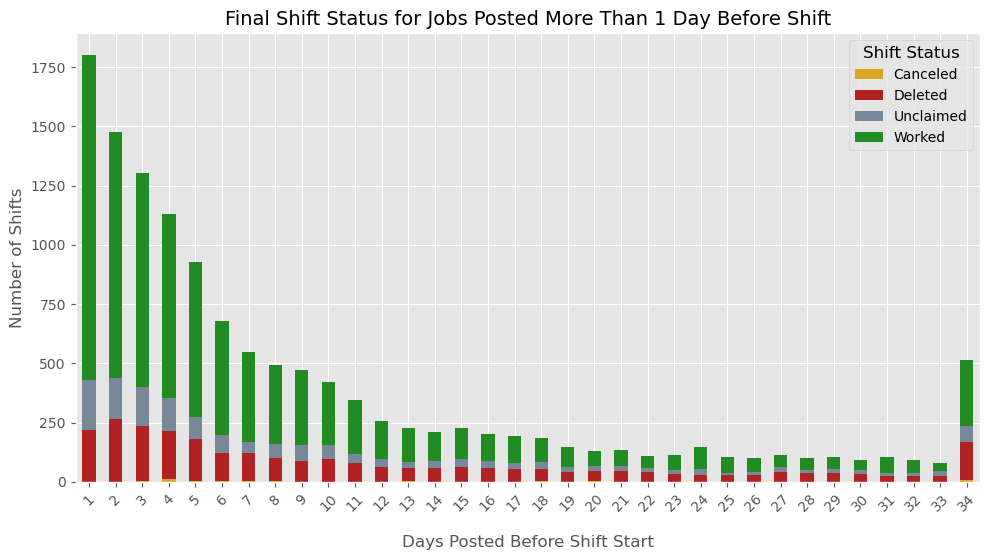

In [21]:
# Filter data for values greater than or equal to 24 hours
over_24_hours = shifts[shifts['time_posted_before_shift_hours'] >= 24]

#convert days 
over_24_hours['days_posted_before_shift'] = (over_24_hours['time_posted_before_shift_hours'] // 24).astype(int)
grouped_days = over_24_hours.groupby(['days_posted_before_shift', 'shift_status']).size().unstack()

ax_days = grouped_days.plot(kind='bar', stacked=True, figsize=(10, 6), color=status_colors)

plt.title('Final Shift Status for Jobs Posted More Than 1 Day Before Shift', fontsize=14)
plt.xlabel('Days Posted Before Shift Start', fontsize=12, labelpad=15)  
plt.ylabel('Number of Shifts', fontsize=12)

plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
handles, labels = ax_days.get_legend_handles_labels()
plt.legend(handles, ['Canceled', 'Deleted', 'Unclaimed', 'Worked'],
           title='Shift Status', fontsize=10,
           title_fontsize=12, loc='upper right')

plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()

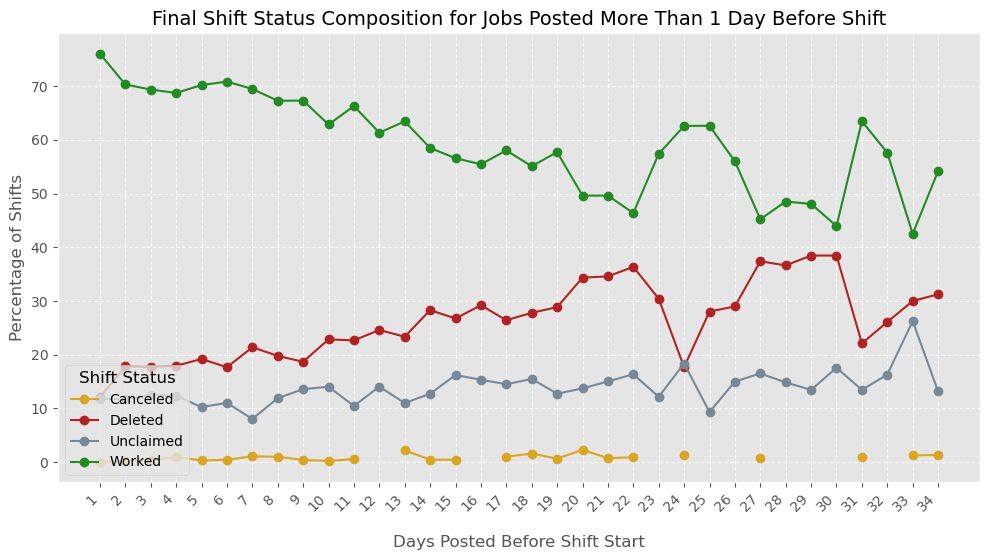

In [22]:
# Calculate percentages for each group
percentages_days = grouped_days.apply(lambda x: x / x.sum() * 100, axis=1)
plt.figure(figsize=(10, 6))  

for status in percentages_days.columns:
    plt.plot(percentages_days.index.astype(str), percentages_days[status], marker='o', 
             label=status, color=status_colors.get(status))

plt.title('Final Shift Status Composition for Jobs Posted More Than 1 Day Before Shift', fontsize=14)
plt.xlabel('Days Posted Before Shift Start', fontsize=12, labelpad=15)
plt.ylabel('Percentage of Shifts', fontsize=12)
plt.xticks(rotation=45,ha='right', fontsize=10)  
plt.yticks(fontsize=10)
plt.legend(title='Shift Status', fontsize=10, title_fontsize=12, loc='lower left')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()

In [23]:
perc_worked = round(len(shifts.loc[shifts['shift_status'] == 'Worked'])/len(shifts) * 100, 1)

print(f'Of the posted shifts, {perc_worked}% were filled as needed by workers utilizing the platform.')

Of the posted shifts, 63.0% were filled as needed by workers utilizing the platform.


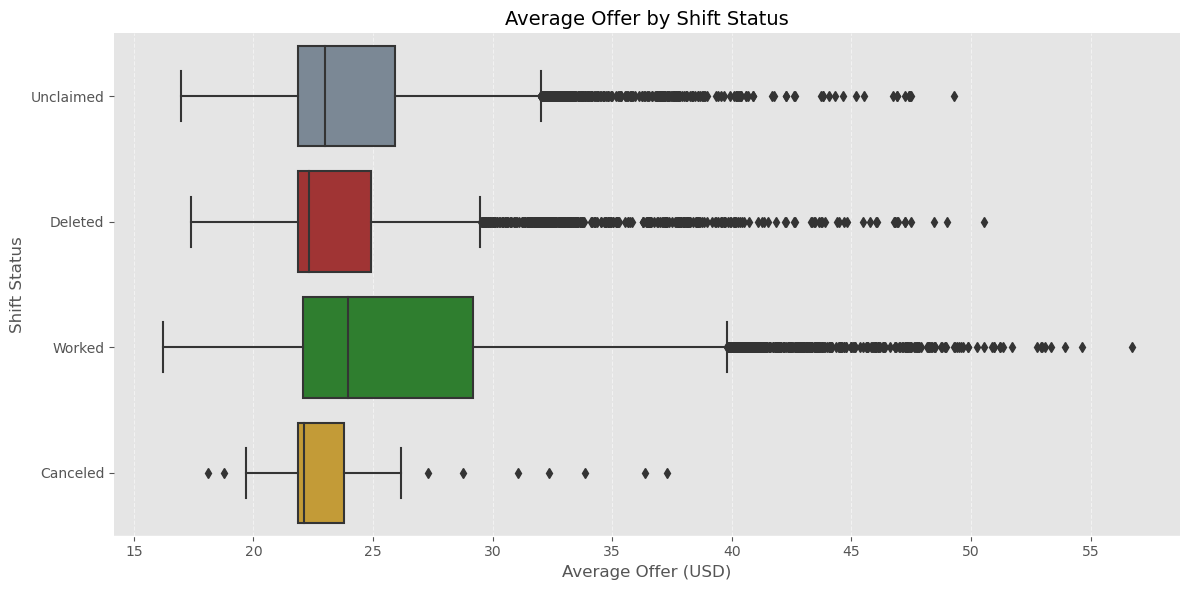

In [25]:
# Box plot on average offers by shift status
plt.figure(figsize=(12, 6))  

ax = sns.boxplot(y='shift_status', x='avg_offer', data=shifts, palette=status_colors)

plt.title('Average Offer by Shift Status', fontsize=14)
plt.xlabel('Average Offer (USD)', fontsize=12)
plt.ylabel('Shift Status', fontsize=12)

sns.despine(left=True)  
ax.xaxis.grid(True, linestyle='--', alpha=0.5) 

plt.tight_layout()
plt.show()

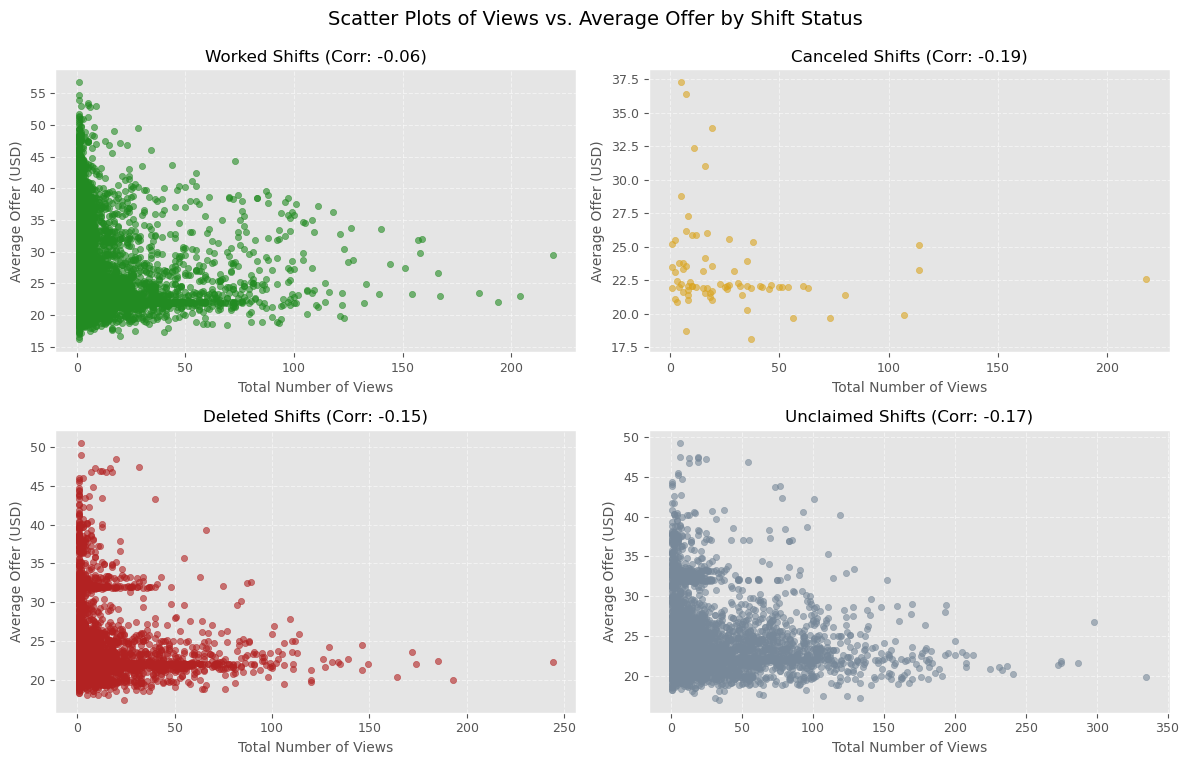

Correlation coefficient for 'Worked' shifts: -0.06
Correlation coefficient for 'Canceled' shifts: -0.19
Correlation coefficient for 'Deleted' shifts: -0.15
Correlation coefficient for 'Unclaimed' shifts: -0.17


In [26]:
shift_statuses = ['Worked', 'Canceled', 'Deleted', 'Unclaimed']

#2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(12, 8))


axes = axes.flatten()
correlations = {}

for i, status in enumerate(shift_statuses):
    subset = shifts[shifts['shift_status'] == status]
    
    if len(subset) > 1:
        correlation = np.corrcoef(subset['total_num_views'], subset['avg_offer'])[0, 1]
    else:
        correlation = np.nan

    correlations[status] = correlation

    ax = axes[i]
    color = status_colors.get(status)  
    if color:
        ax.scatter(subset['total_num_views'], subset['avg_offer'], color=color, s=20, alpha=0.6) 
    else:  
        ax.scatter(subset['total_num_views'], subset['avg_offer'], color='skyblue', s=20, alpha=0.6)  

    ax.set_xlabel('Total Number of Views', fontsize=10)
    ax.set_ylabel('Average Offer (USD)', fontsize=10)
    ax.set_title(f'{status} Shifts (Corr: {correlation:.2f})', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.tick_params(labelsize=9)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Scatter Plots of Views vs. Average Offer by Shift Status', fontsize=14)
plt.show()

for status, correlation in correlations.items():
    print(f"Correlation coefficient for '{status}' shifts: {correlation:.2f}")

In [27]:
# Pivot of views by shift status
median_views_by_status = shifts.pivot_table(
    values='total_num_views',  
    index='shift_status',       
    aggfunc='median'            
)
median_views_by_status

,total_num_views
shift_status,
Canceled,17
Deleted,7
Unclaimed,18
Worked,2


In [41]:
# Pivot of median of distributed offers by shift status
median_offer_by_status = shifts.pivot_table(
    values='avg_offer',  
    index='shift_status',       
    aggfunc='median'          
)
median_offer_by_status = median_offer_by_status.rename(columns={'avg_offer': 'overall median of distributed offers'})
median_offer_by_status

,overall median of distributed offers
shift_status,
Canceled,22.10
Deleted,22.34
Unclaimed,22.99
Worked,23.94


In [40]:
print(f"Overall median of distributed offers: {np.median(shifts['avg_offer'])}")

Overall median of distributed offers: 23.43


In [29]:
# Pvot of shift status percentage by shift slot
slot_pivot_table = pd.pivot_table(shifts, index='shift_slot', columns='shift_status', aggfunc='size', fill_value=0)
slot_pivot_table = slot_pivot_table.div(slot_pivot_table.sum(axis=1), axis=0) * 100

slot_pivot_table.style.format("{:.1f}%")

shift_status,Canceled,Deleted,Unclaimed,Worked
shift_slot,,,,
am,0.5%,16.6%,21.6%,61.4%
noc,0.2%,16.3%,15.2%,68.2%
pm,0.4%,20.8%,17.3%,61.5%


In [30]:
len(shifts[shifts['shift_slot']=='noc'])/len(shifts) # Percentage of overnight shifts

0.23271356783919597